In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import copy
from hendrics.fake import filter_for_deadtime
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum, AveragedCrossspectrum


import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray.utils import rebin_data

np.random.seed(348172694)

from stingray import Lightcurve, Crossspectrum
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d


np.random.seed(1209432)

## Finally: red noise

In [2]:
from hendrics.io import load_events, load_lcurve, load_pds, save_lcurve, save_pds
from stingray.gti import cross_two_gtis
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum, AveragedCrossspectrum

file_label = 'rednoise_'

In [3]:
from astropy.modeling.models import Lorentz1D
from stingray.events import EventList

tstart = 0
tstop = 8196
dt = 1/512

lc_dt = 1/2048

time = np.arange(tstart, tstop, dt)
mean_ctrate = 200
rms = 0.25

sim = Simulator(N=len(time), dt=dt, rms=0.7, mean=mean_ctrate, red_noise=3)
model = Lorentz1D(x_0=0, fwhm=1, amplitude=1000) + Lorentz1D(x_0=30, fwhm=30, amplitude=20)



<IPython.core.display.Javascript object>


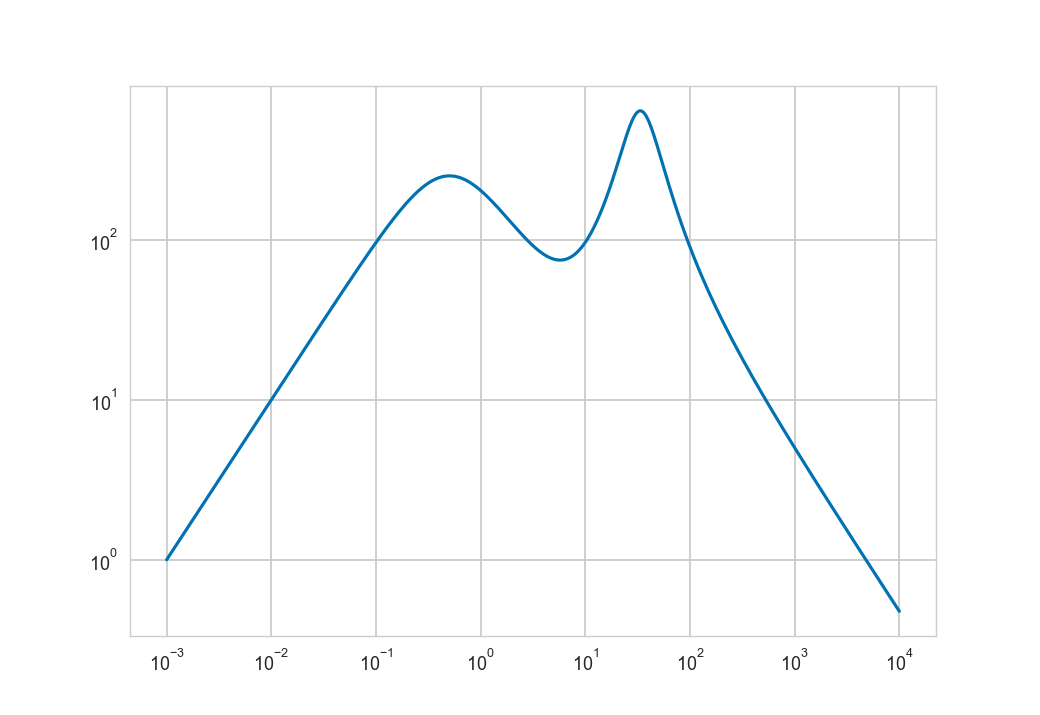

In [4]:
freqs = np.logspace(-3, 4, 1000)
plt.figure()
plt.loglog(freqs, model(freqs) * freqs)

In [5]:
sim_lc_clean = sim.simulate(model)
sim_lc_clean.counts *= dt

sim_lc_clean.counts -= (np.min(sim_lc_clean.counts) - 100 * dt)

In [6]:
events = EventList()
events.simulate_times(sim_lc_clean)
whitenoise_ev_1 = events.time

events.simulate_times(sim_lc_clean)
whitenoise_ev_2 = events.time

lc1_clean = Lightcurve.make_lightcurve(whitenoise_ev_1, 
                                       gti=[[tstart, tstop]], 
                                       tstart=tstart, tseg=tstop - tstart, dt=lc_dt)
lc2_clean = Lightcurve.make_lightcurve(whitenoise_ev_2, 
                                       gti=[[tstart, tstop]], 
                                       tstart=tstart, tseg=tstop - tstart, dt=lc_dt)

wn_ev_1_dt = filter_for_deadtime(whitenoise_ev_1, 2.5e-3)
wn_ev_2_dt = filter_for_deadtime(whitenoise_ev_2, 2.5e-3)

In [7]:
lc1 = Lightcurve.make_lightcurve(wn_ev_1_dt, gti=[[tstart, tstop]], tstart=tstart, tseg=tstop - tstart, dt=lc_dt)
lc2 = Lightcurve.make_lightcurve(wn_ev_2_dt, gti=[[tstart, tstop]], tstart=tstart, tseg=tstop - tstart, dt=lc_dt)

In [8]:
from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from stingray.gti import bin_intervals_from_gtis
from hendrics.base import r_in, r_det
from fad_correction import *

countrate_ratio = lc1.meanrate / lc2.meanrate
segment_size=512

freqs, pds1_norm, pds2_norm, crosssp_norm, ptot_norm = \
    FAD_power_spectra(lc1, lc2, segment_size)

print('Fourier Amplitudes loaded')

Fourier Amplitudes loaded


In [9]:
pds1_dt = AveragedPowerspectrum(lc1, segment_size=segment_size, norm="frac")
del pds1_dt.cs_all
del pds1_dt.lc1, pds1_dt.lc2
save_pds(pds1_dt, file_label + 'pds1_dt.nc')
del pds1_dt

In [10]:
pds2_dt = AveragedPowerspectrum(lc2, segment_size=segment_size, norm="frac")
del pds2_dt.cs_all
del pds2_dt.lc1, pds2_dt.lc2
save_pds(pds2_dt, file_label + 'pds2_dt.nc')
del pds2_dt

In [11]:
pdstot_norm = load_pds(file_label + 'pds1_dt.nc')

pdstot_norm.norm = 'none'
pdstot_norm.power = ptot_norm
pdstot_norm.power = pdstot_norm.power / pdstot_norm.n**2 
pdstot_norm.power = pdstot_norm.power * 2 * segment_size / (lc1.meancounts + lc2.meancounts) **2

save_pds(pdstot_norm, file_label + 'pdstot_norm.nc')

In [12]:
pds_norm = load_pds(file_label + 'pds1_dt.nc')

pds_norm.norm = 'none'
pds_norm.power = pds1_norm
pds_norm.power = pds_norm.power / pds_norm.n**2 
pds_norm.power = pds_norm.power * 2 * segment_size / lc1.meancounts **2

save_pds(pds_norm, file_label + 'pds_norm.nc')

In [13]:
cs_dt = AveragedCrossspectrum(lc1, lc2, segment_size=segment_size, norm="frac")
del cs_dt.cs_all
del cs_dt.lc1, cs_dt.lc2
del cs_dt.pds1, cs_dt.pds2
save_pds(cs_dt, file_label + 'cs_dt.nc')
del cs_dt

In [14]:
cs_norm = load_pds(file_label + 'cs_dt.nc')
cs_norm.norm = 'none'
cs_norm.power = crosssp_norm
cs_norm.power = cs_norm.power / cs_norm.n**2 
cs_norm.power = cs_norm.power * 2 * segment_size / (lc1.meancounts * lc2.meancounts)

save_pds(cs_norm, file_label + 'cs_norm.nc')
del cs_norm

In [15]:
del lc1
del lc2

In [34]:
def load_rebinned(file, rebin_factor, kind='lin'):
    periodogram = load_pds(file)
    if kind == 'lin' and isinstance(rebin_factor, int):
        return periodogram.rebin(f=rebin_factor)
    elif kind == 'lin':
        return periodogram.rebin(df=rebin_factor)
    else:
        return periodogram.rebin_log(rebin_factor)
    
rebin_factor = 0.02
cs_dt_reb = load_rebinned(file_label + 'cs_dt.nc', rebin_factor)
cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
pds_norm_reb = load_rebinned(file_label + 'pds_norm.nc', rebin_factor)
pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
pds1_dt_reb = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor)

<IPython.core.display.Javascript object>


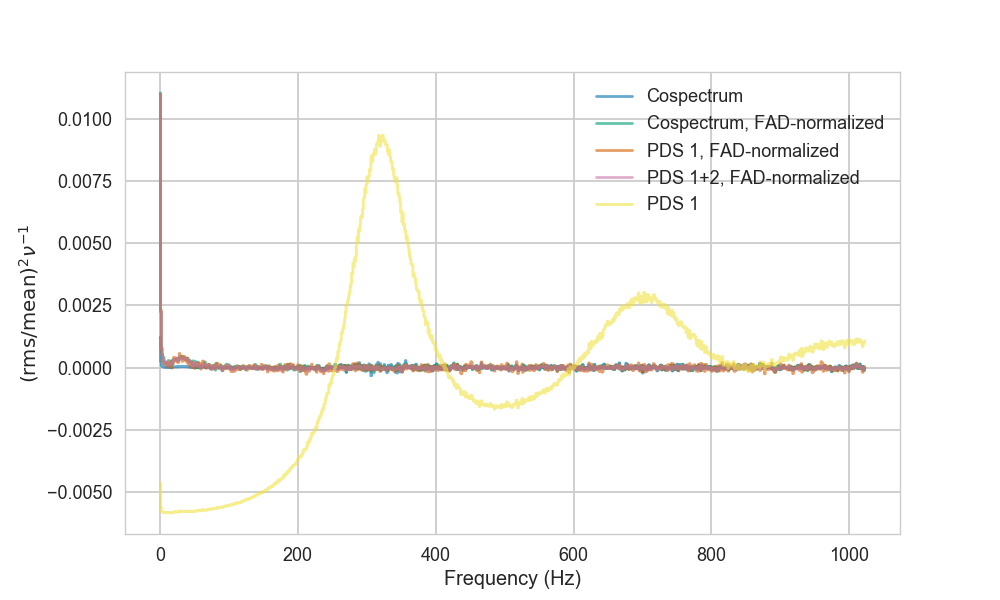

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(cs_dt_reb.freq, cs_dt_reb.power, alpha=0.6, label='Cospectrum', 
         lw=2, drawstyle='steps-mid')

ax1.plot(cs_norm_reb.freq, cs_norm_reb.power, alpha=0.6, label='Cospectrum, FAD-normalized', 
         lw=2, drawstyle='steps-mid')

good = pds_norm_reb.freq > 30

# print(pds_norm.power.real[good], power_norm)
lev = np.mean(pds_norm_reb.power.real[good])
ax1.plot(pds_norm_reb.freq, pds_norm_reb.power - lev, alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=2, drawstyle='steps-mid')

lev = np.mean(pdstot_norm_reb.power.real[good])
ax1.plot(pdstot_norm_reb.freq, pdstot_norm_reb.power - lev, alpha=0.6, 
         label='PDS 1+2, FAD-normalized', 
         lw=2, drawstyle='steps-mid')

lev = np.mean(pds1_dt_reb.power.real[good])
ax1.plot(pds1_dt_reb.freq, pds1_dt_reb.power - lev, alpha=0.6, label='PDS 1', 
         lw=2, drawstyle='steps-mid')

ax1.legend(loc=1)

# ax1.set_xlim([0.5, 1000])
# ax1.set_ylim([1e-4, None])

ax1.set_xlabel('Frequency (Hz)')

ax1.set_ylabel(r'${(\rm rms/mean)}^2 \nu^{-1}$')
plt.savefig('rednoise.jpg')

<IPython.core.display.Javascript object>


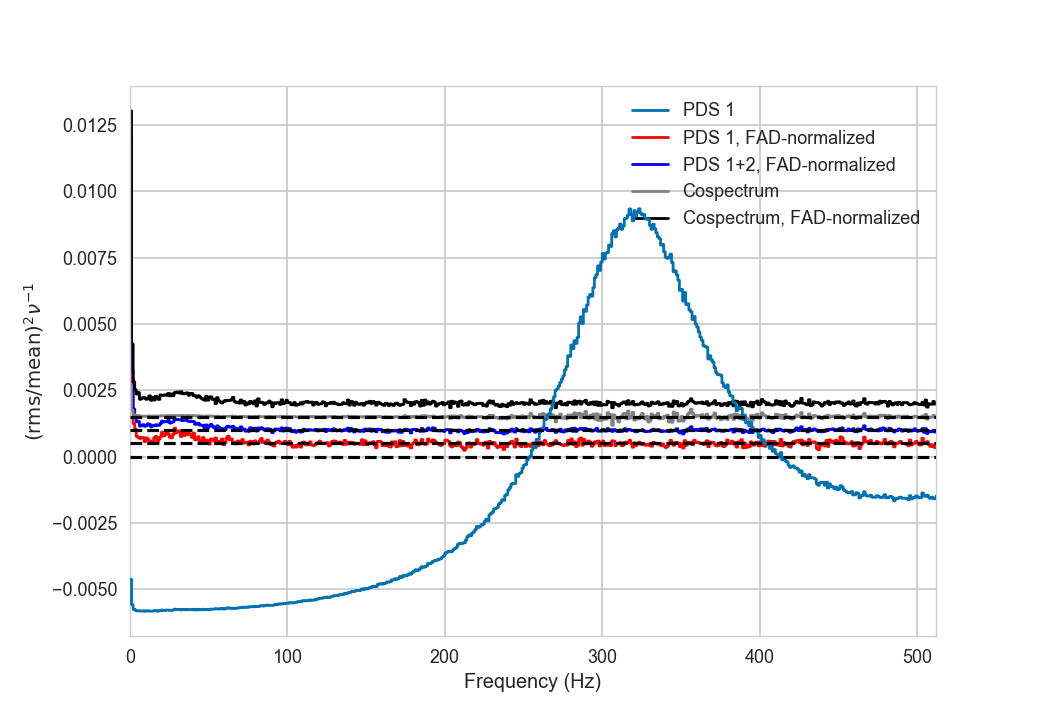

In [18]:
lw=2
step = 0.0005
plt.figure()
plt.plot(pds1_dt_reb.freq, pds1_dt_reb.power - np.mean(pds1_dt_reb.power[good]), 
         label='PDS 1', drawstyle='steps-mid', zorder=10, lw=lw)
# plt.plot(pds2_dt.freq, pds2_dt.power, alpha=0.5, label='PDS 2', drawstyle='steps-mid')
plt.plot(pds_norm_reb.freq, pds_norm_reb.power - np.mean(pds_norm_reb.power[good]) + step, 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, color='r')
plt.plot(pdstot_norm_reb.freq, pdstot_norm_reb.power - np.mean(pdstot_norm_reb.power[good]) + 2*step, 
         label='PDS 1+2, FAD-normalized', drawstyle='steps-mid', lw=lw, color='b')
plt.plot(cs_dt_reb.freq, cs_dt_reb.power + 3 * step, 
         label='Cospectrum', drawstyle='steps-mid', lw=lw, color='grey')
plt.plot(cs_norm_reb.freq, cs_norm_reb.power + 4 * step, 
         label='Cospectrum, FAD-normalized', drawstyle='steps-mid', lw=lw, color='k')
plt.legend(loc=1)

for i in range(4):
    plt.axhline(step * i, ls = '--', color='k', zorder=20)
# plt.ylim([-2 * step, 5 * step])
plt.xlim([0, 512])
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

plt.savefig('rednoise_rebin.jpg')

<IPython.core.display.Javascript object>


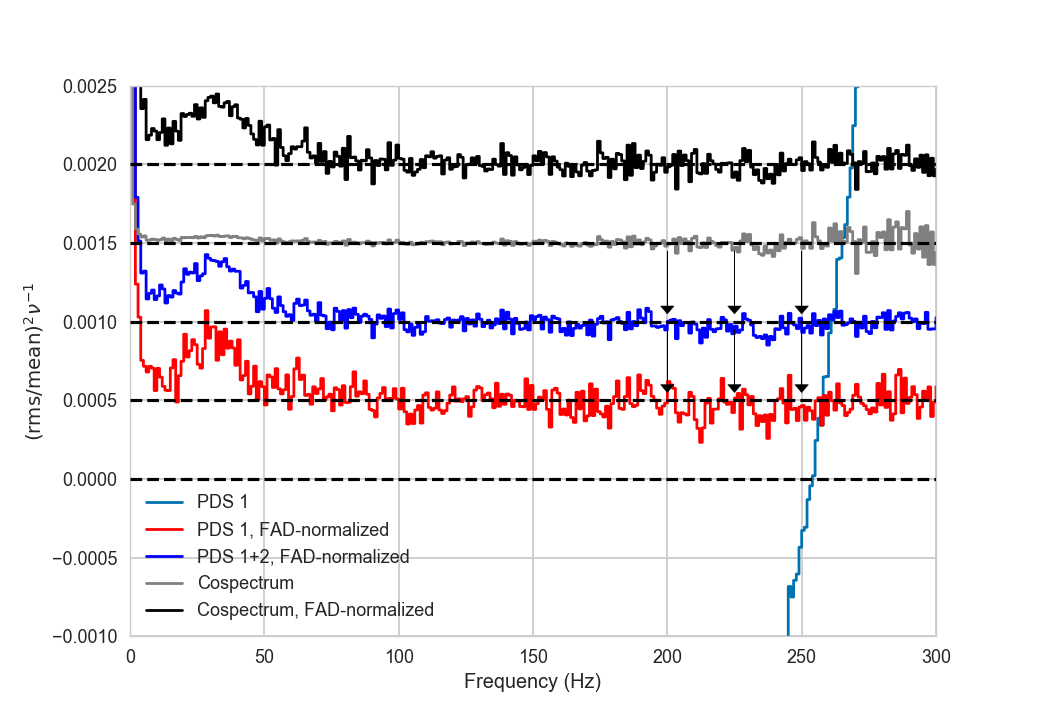

In [19]:
lw=2
step = 0.0005
plt.figure()
plt.plot(pds1_dt_reb.freq, pds1_dt_reb.power - np.mean(pds1_dt_reb.power[good]), 
         label='PDS 1', drawstyle='steps-mid', lw=lw)
# plt.plot(pds2_dt.freq, pds2_dt.power, alpha=0.5, label='PDS 2', drawstyle='steps-mid')
plt.plot(pds_norm_reb.freq, pds_norm_reb.power - np.mean(pds_norm_reb.power[good]) + step, 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, color='r')
plt.plot(pdstot_norm_reb.freq, pdstot_norm_reb.power - np.mean(pdstot_norm_reb.power[good]) + 2*step, 
         label='PDS 1+2, FAD-normalized', drawstyle='steps-mid', lw=lw, color='b')
plt.plot(cs_dt_reb.freq, cs_dt_reb.power + 3 * step, 
         label='Cospectrum', drawstyle='steps-mid', lw=lw, color='grey')
plt.plot(cs_norm_reb.freq, cs_norm_reb.power + 4 * step, 
         label='Cospectrum, FAD-normalized', drawstyle='steps-mid', lw=lw, color='k')
plt.legend()

for i in range(5):
    plt.axhline(step * i, ls = '--', color='k', zorder=20)

plt.arrow(200, 2 * step - step / 10, 0, -step *0.7, fc='k', ec='k', head_width=5, head_length=step * 0.1,zorder=10)
plt.arrow(225, 2 * step - step / 10, 0, -step *0.7, fc='k', ec='k', head_width=5, head_length=step * 0.1,zorder=10)
plt.arrow(250, 2 * step - step / 10, 0, -step *0.7, fc='k', ec='k', head_width=5, head_length=step * 0.1,zorder=10)
plt.arrow(200, 3 * step - step / 10, 0, -step *0.7, fc='k', ec='k', head_width=5, head_length=step * 0.1,zorder=10)
plt.arrow(225, 3 * step - step / 10, 0, -step *0.7, fc='k', ec='k', head_width=5, head_length=step * 0.1,zorder=10)
plt.arrow(250, 3 * step - step / 10, 0, -step *0.7, fc='k', ec='k', head_width=5, head_length=step * 0.1,zorder=10)

plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

plt.ylim([-2 * step, 5 * step])
plt.xlim([0, 300])

plt.savefig('rednoise_rebin_zoom.jpg')

In [20]:
rebin_factor = 0.02
cs_dt_reb_log = load_rebinned(file_label + 'cs_dt.nc', rebin_factor, kind='log')
cs_norm_reb_log = load_rebinned(file_label + 'cs_norm.nc', rebin_factor, kind='log')
pds_norm_reb_log = load_rebinned(file_label + 'pds_norm.nc', rebin_factor, kind='log')
pdstot_norm_reb_log = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor, kind='log')
pds1_dt_reb_log = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor, kind='log')

<IPython.core.display.Javascript object>


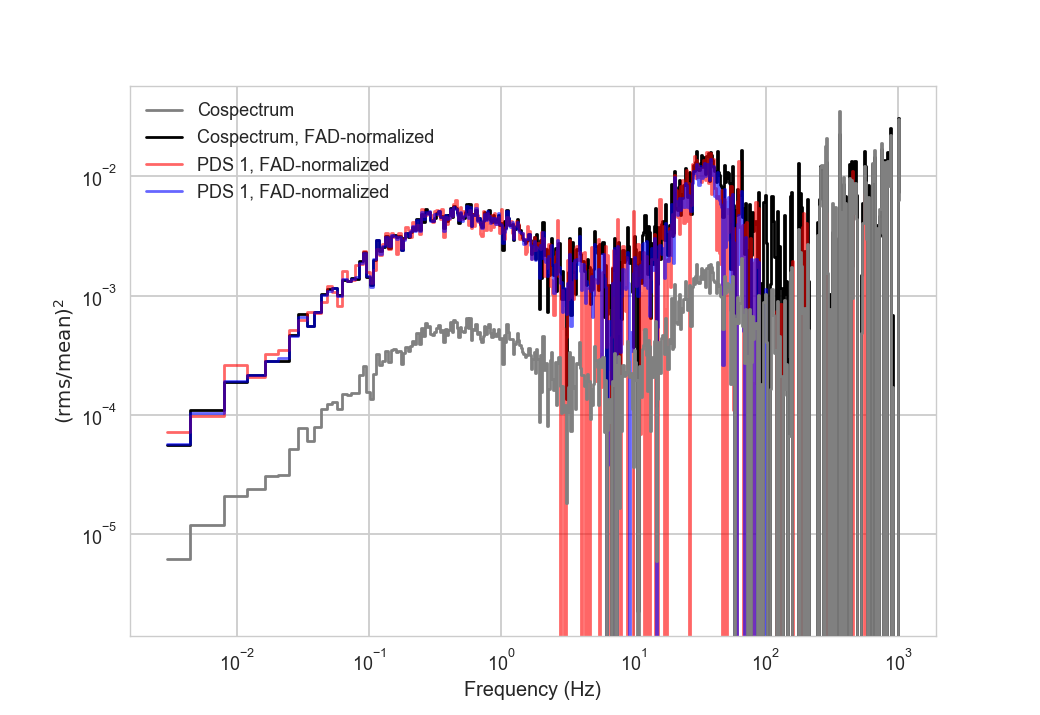

In [21]:
lw=2
fig, ax1 = plt.subplots()

ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_reb_log.power, label='Cospectrum', 
         lw=lw, drawstyle='steps-mid', color='grey', zorder=3)

ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_reb_log.power, label='Cospectrum, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='k')

good = pds_norm_reb_log.freq > 30

lev = np.mean(pds_norm_reb_log.power.real[good])
ax1.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq*(pds_norm_reb_log.power - lev), alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='r')

lev = np.mean(pdstot_norm_reb_log.power.real[good])
ax1.plot(pdstot_norm_reb_log.freq, pdstot_norm_reb_log.freq*(pdstot_norm_reb_log.power - lev), alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='b')

ax1.legend()
ax1.set_yscale('log', nonposy='clip')

ax1.set_xscale('log', nonposx='clip')

# ax1.set_xlim([0.005, 100])
# ax1.set_ylim([1e-4, None])

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel(r'${(\rm rms/mean)}^2$')
# ax2.set_ylabel(r'$P_{\rm FAD} - P_{\rm no\,dt}$')
plt.savefig('rednoise_rebin_log.jpg')

In [22]:
from stingray.modeling import fit_powerspectrum
from astropy.modeling.models import Lorentz1D, Const1D

model_pds = Lorentz1D(x_0=0, fwhm=1, amplitude=0.02) + Lorentz1D(x_0=30, fwhm=30, amplitude=0.002) + Const1D(0.02)
model_pds.x_0_0.bounds = [0, 0]

model_cs = Lorentz1D(x_0=0, fwhm=1, amplitude=0.02) + Lorentz1D(x_0=30, fwhm=30, amplitude=0.002)
model_cs.x_0_0.bounds = [0, 0]


In [35]:
from stingray.modeling import ParameterEstimation, GaussianLogLikelihood

good = cs_dt_reb.freq < 500

lpost = GaussianLogLikelihood(cs_dt_reb.freq[good], cs_dt_reb.power[good], 
                              np.sqrt(2/cs_dt_reb.m), copy.deepcopy(model_cs))

cs_dt_parest = ParameterEstimation()
cs_dt_res = cs_dt_parest.fit(lpost, model_cs.parameters)

# cs_dt_parest, cs_dt_res = fit_powerspectrum(cs_dt_reb, copy.deepcopy(model_cs), model_cs.parameters)

In [36]:
good = cs_norm_reb.freq < 500

lpost = GaussianLogLikelihood(cs_norm_reb.freq[good], cs_norm_reb.power[good], 
                              np.sqrt(2/cs_norm_reb.m), copy.deepcopy(model_cs))

cs_norm_parest = ParameterEstimation()
cs_norm_res = cs_norm_parest.fit(lpost, model_cs.parameters)

# cs_norm_parest, cs_norm_res = fit_powerspectrum(cs_norm_reb, copy.deepcopy(model_cs), model_cs.parameters)

In [37]:
good = pds_norm_reb.freq < 500

lpost = GaussianLogLikelihood(pds_norm_reb.freq[good], pds_norm_reb.power[good], 
                              np.sqrt(4/pds_norm_reb.m), copy.deepcopy(model_pds))

pds_norm_parest = ParameterEstimation()
pds_norm_res = pds_norm_parest.fit(lpost, model_pds.parameters)

# pds_norm_parest, pds_norm_res = fit_powerspectrum(pds_norm_reb, copy.deepcopy(model_pds), model_pds.parameters)

In [38]:
good = pdstot_norm_reb.freq < 500

lpost = GaussianLogLikelihood(pdstot_norm_reb.freq[good], pdstot_norm_reb.power[good], 
                              np.sqrt(4/pds_norm_reb.m), copy.deepcopy(model_pds))

pdstot_norm_parest = ParameterEstimation()
pdstot_norm_res = pdstot_norm_parest.fit(lpost, model_pds.parameters)

# pds_norm_parest, pds_norm_res = fit_powerspectrum(pds_norm_reb, copy.deepcopy(model_pds), model_pds.parameters)

In [39]:
cs_dt_res.model, cs_norm_res.model, pds_norm_res.model

(<CompoundModel3(amplitude_0=0.0021200748619798556, x_0_0=0.0, fwhm_0=1.0671135736966477, amplitude_1=4.586911556086497e-05, x_0_1=30.090124166017233, fwhm_1=30.052570397316124)>,
 <CompoundModel3(amplitude_0=0.01990229082360911, x_0_0=0.0, fwhm_0=0.995292667816468, amplitude_1=0.0004096444525579, x_0_1=29.712778097044925, fwhm_1=29.65334139170904)>,
 <CompoundModel2(amplitude_0=0.020218424359786057, x_0_0=0.0, fwhm_0=0.9736366605498168, amplitude_1=0.00038696309200462954, x_0_1=29.499000577971643, fwhm_1=29.454237141453238, amplitude_2=0.007486788682008215)>)

<IPython.core.display.Javascript object>


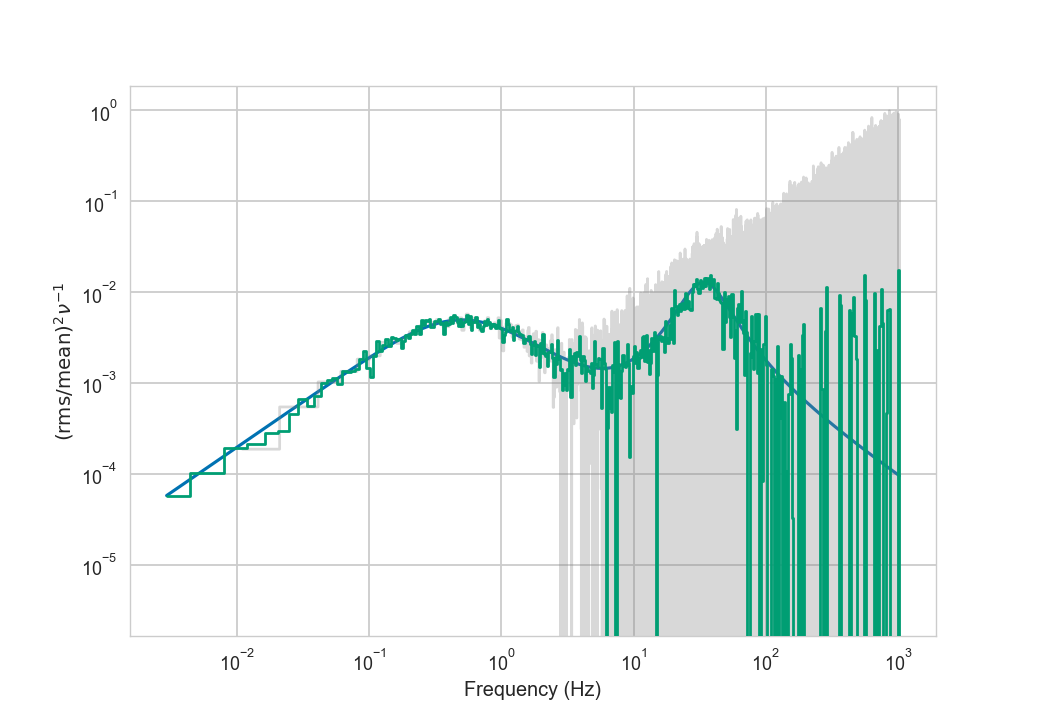

In [40]:
lw=2
plt.figure()
plt.plot(pdstot_norm_reb_log.freq, pdstot_norm_reb_log.freq*(pdstot_norm_res.model(pdstot_norm_reb_log.freq) - pdstot_norm_res.model.amplitude_2))
# plt.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq*(model_pds(pds_norm_reb_log.freq) - model_pds.amplitude_2))
good = pdstot_norm_reb.freq > 30

plt.plot(pdstot_norm_reb_log.freq, pdstot_norm_reb_log.freq * (pdstot_norm_reb_log.power - np.mean(pdstot_norm_reb.power[good])), 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, zorder=3)
plt.plot(pdstot_norm_reb.freq, pdstot_norm_reb.freq * (pdstot_norm_reb.power - np.mean(pdstot_norm_reb.power[good])), 
         color='grey', alpha=0.3, drawstyle='steps-mid', lw=lw)

plt.gca().set_yscale('log', nonposy='clip')

plt.gca().set_xscale('log', nonposx='clip')


plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

# plt.savefig('nustar_2_rebin.jpg')

<IPython.core.display.Javascript object>


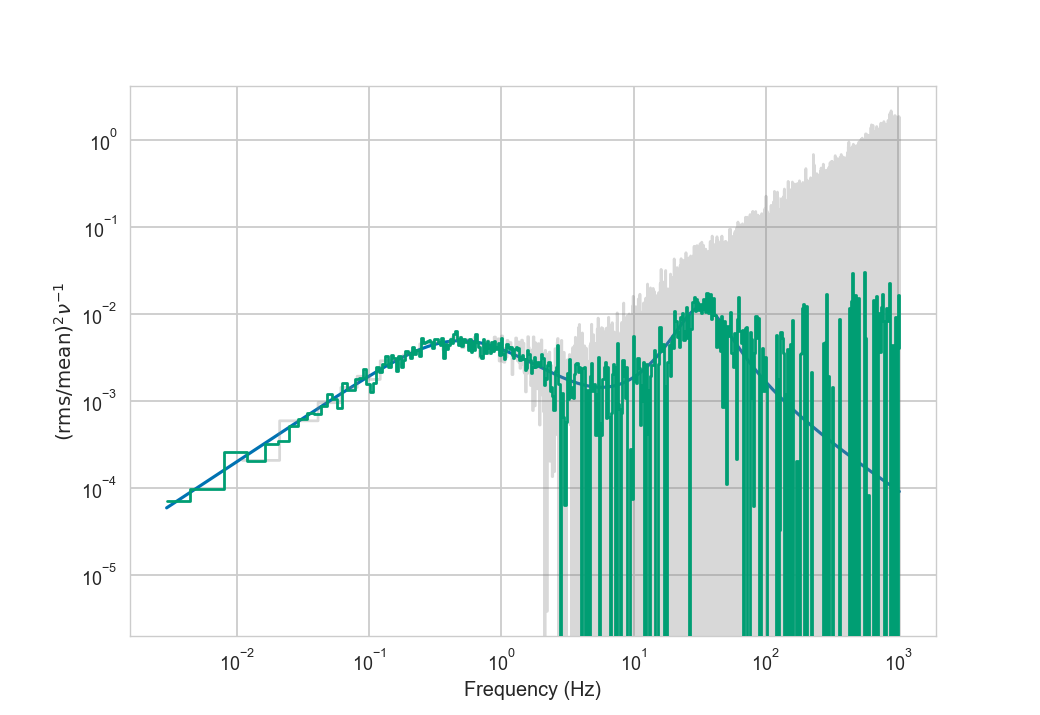

In [41]:
lw=2
plt.figure()
plt.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq*(pds_norm_res.model(pds_norm_reb_log.freq) - pds_norm_res.model.amplitude_2))
# plt.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq*(model_pds(pds_norm_reb_log.freq) - model_pds.amplitude_2))
good = pds_norm_reb.freq > 30

plt.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq * (pds_norm_reb_log.power - np.mean(pds_norm_reb.power[good])), 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, zorder=3)
plt.plot(pds_norm_reb.freq, pds_norm_reb.freq * (pds_norm_reb.power - np.mean(pds_norm_reb.power[good])), 
         color='grey', alpha=0.3, drawstyle='steps-mid', lw=lw)

plt.gca().set_yscale('log', nonposy='clip')

plt.gca().set_xscale('log', nonposx='clip')


plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

# plt.savefig('nustar_2_rebin.jpg')

<IPython.core.display.Javascript object>


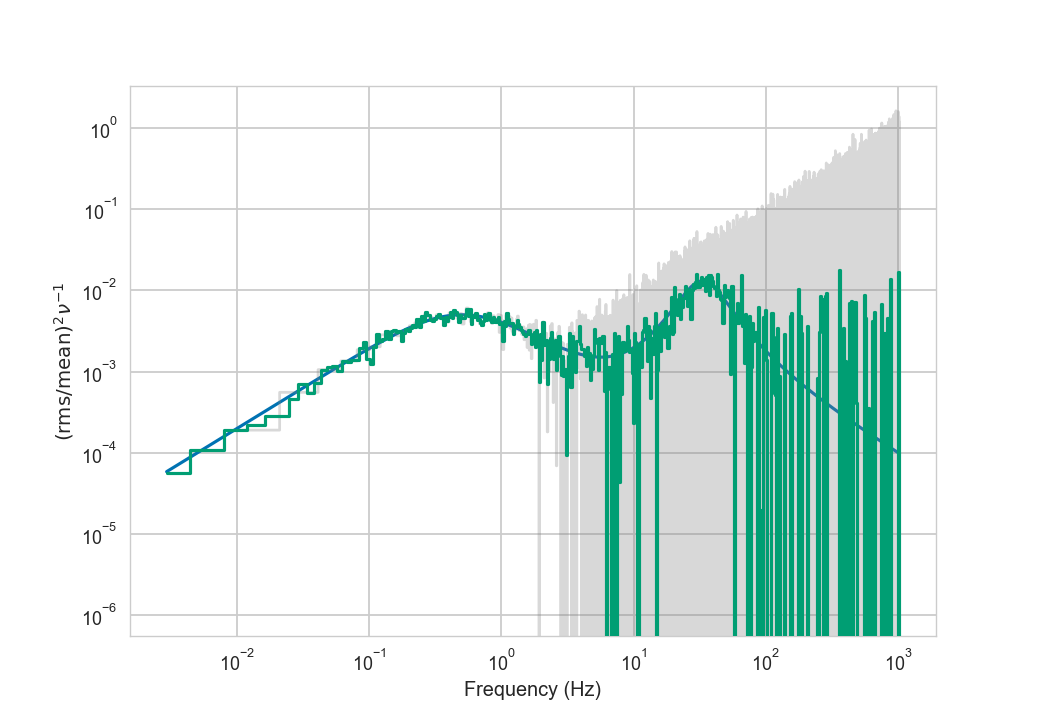

In [42]:
lw=2
plt.figure()
plt.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_res.model(cs_norm_reb_log.freq))
good = cs_norm_reb.freq > 30

plt.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq * (cs_norm_reb_log.power - np.mean(cs_norm_reb.power[good])), 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', zorder=3)
plt.plot(cs_norm_reb.freq, cs_norm_reb.freq * (cs_norm_reb.power - np.mean(cs_norm_reb.power[good])), 
         color='grey', alpha=0.3, drawstyle='steps-mid', lw=lw)

plt.gca().set_yscale('log', nonposy='clip')

plt.gca().set_xscale('log', nonposx='clip')


plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

# plt.savefig('nustar_2_rebin.jpg')

<IPython.core.display.Javascript object>


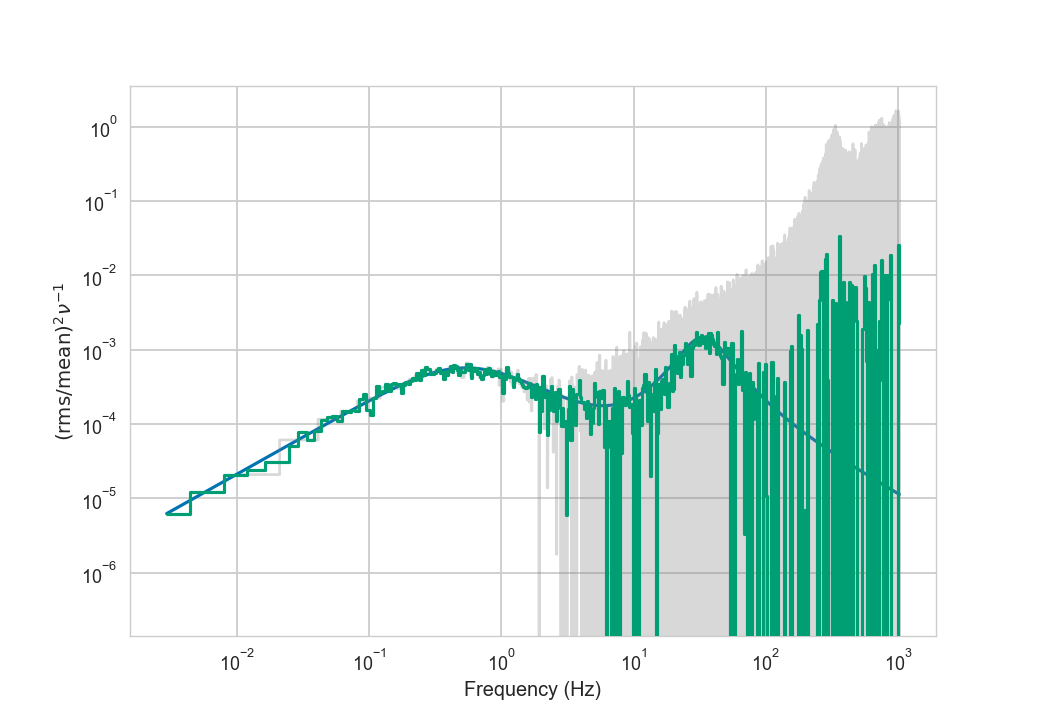

In [43]:
lw=2
plt.figure()
plt.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_res.model(cs_dt_reb_log.freq))
good = cs_dt_reb.freq > 30

plt.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq * (cs_dt_reb_log.power - np.mean(cs_dt_reb.power[good])), 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', zorder=3)
plt.plot(cs_dt_reb.freq, cs_dt_reb.freq * (cs_dt_reb.power - np.mean(cs_dt_reb.power[good])), 
         color='grey', alpha=0.3, drawstyle='steps-mid', lw=lw)

plt.gca().set_yscale('log', nonposy='clip')

plt.gca().set_xscale('log', nonposx='clip')


plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

# plt.savefig('nustar_2_rebin.jpg')

In [48]:
# def _choose_amplitude(model):
#     if hasattr(model, 'amplitude'):
#         return model.amplitude
#     else:
#         return model.amplitude_0
    
def model_ratio(model1, model2):
    amp1 = model1.amplitude_0 + model1.amplitude_1
    amp2 = model2.amplitude_0 + model2.amplitude_1

    print(amp1**0.5, amp2**0.5, (amp1/amp2)**0.5)
    return amp1/amp2

meanrate = pds_norm.nphots/pds_norm.segment_size
expected_gain = r_in(2.5e-3, meanrate)/meanrate
print(meanrate, r_in(2.5e-3, meanrate))

print("rms gain expected from incident/detected "
      "ratio: {:.2f}".format(expected_gain))
gain_cs = model_ratio(cs_norm_res.model, cs_dt_res.model)**0.5
print("rms gain cs_norm/cs_dt: "
      "{:.2f} (correct to {:.1f}%)".format(gain_cs,
                                       (np.abs(gain_cs - expected_gain) / expected_gain) * 100))

gain_pds = model_ratio(pds_norm_res.model, cs_dt_res.model)**0.5
print("rms gain pds_norm/cs_dt: "
      "{:.2f} (correct to {:.1f}%)".format(gain_pds,
                                       (np.abs(gain_pds - expected_gain) / expected_gain) * 100))

gain_pds = model_ratio(pdstot_norm_res.model, cs_dt_res.model)**0.5
print("rms gain pdstot_norm/cs_dt: "
      "{:.2f} (correct to {:.1f}%)".format(gain_pds,
                                          (np.abs(gain_pds - expected_gain) / expected_gain) * 100))


267.336425781 806.058263862
rms gain expected from incident/detected ratio: 3.02
0.142519946941 0.0465397032386 3.06233037651
rms gain cs_norm/cs_dt: 3.06 (correct to 1.6%)
0.143545767795 0.0465397032386 3.08437221997
rms gain pds_norm/cs_dt: 3.08 (correct to 2.3%)
0.142163983116 0.0465397032386 3.0546817711
rms gain pdstot_norm/cs_dt: 3.05 (correct to 1.3%)


<IPython.core.display.Javascript object>


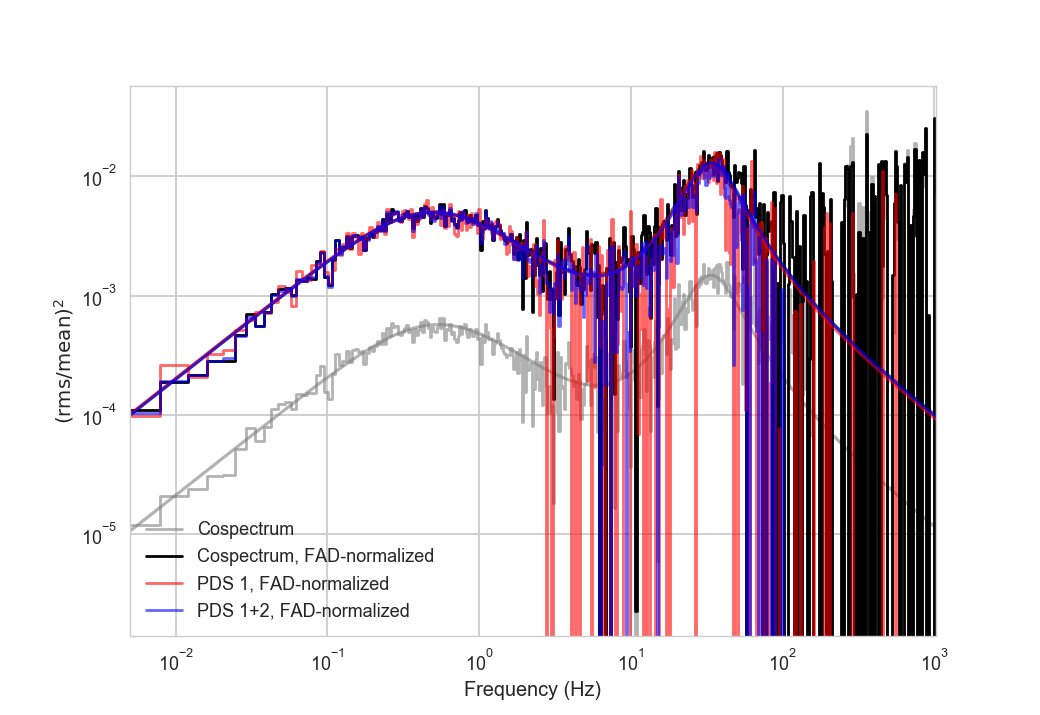

In [45]:
lw=2
fig, ax1 = plt.subplots()

ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_reb_log.power, alpha=0.6, label='Cospectrum', 
         lw=lw, drawstyle='steps-mid', color='grey')
ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_res.model(cs_dt_reb_log.freq), color='grey', alpha=0.6)

ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_reb_log.power, label='Cospectrum, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='k')
ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_res.model(cs_norm_reb_log.freq), color='k', alpha=0.6)

good = pds_norm_reb_log.freq > 30

lev = np.mean(pds_norm_reb_log.power.real[good])
ax1.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq*(pds_norm_reb_log.power - lev), 
         alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='r')
plt.plot(pds_norm_reb_log.freq, 
         pds_norm_reb_log.freq*(pds_norm_res.model(pds_norm_reb_log.freq) - pds_norm_res.model.amplitude_2),
         alpha=0.6, color='r')

lev = np.mean(pdstot_norm_reb_log.power.real[good])
ax1.plot(pdstot_norm_reb_log.freq, pdstot_norm_reb_log.freq*(pdstot_norm_reb_log.power - lev), 
         alpha=0.6, label='PDS 1+2, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='b')
plt.plot(pdstot_norm_reb_log.freq, 
         pdstot_norm_reb_log.freq*(pdstot_norm_res.model(pdstot_norm_reb_log.freq) - pdstot_norm_res.model.amplitude_2),
         alpha=0.6, color='b')


ax1.legend()
ax1.set_yscale('log', nonposy='clip')

ax1.set_xscale('log', nonposx='clip')

ax1.set_xlim([0.005, 1024])
# ax1.set_ylim([1e-4, None])

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel(r'${(\rm rms/mean)}^2$')
# ax2.set_ylabel(r'$P_{\rm FAD} - P_{\rm no\,dt}$')
plt.savefig('simu_rebin_log.jpg')